In [1]:
%matplotlib inline
import os, sys
import numpy as np
import numpy.matlib
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
import pandas as pd

In [2]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

xarray==0.12.3
pandas==0.25.0
numpy==1.15.4
netCDF4==1.5.3
matplotlib==2.2.3


# Input data location and time interval

In [3]:
path_out_1 = '/glade/scratch/domingom/FastEddy_2022/FE_release/test_v16_AllExamples/Example04_BOMEX/output/'
path_pre = '/glade/scratch/domingom/FastEddy_2022/FE_release/test_v16_AllExamples/Example04_BOMEX/output_pre/'
path_sieb = '/glade/scratch/domingom/FastEddy_2022/FE_release/test_v16_AllExamples/BOMEX_Siebesma2003_models/'
save_plot_opt = 1
folder_figs_name = 'Figures_BOMEX'
###

path_out_v = []
path_out_v.append(path_out_1)

legend_1 = r'CTRL'

legend_v = []
legend_v.append(legend_1)

colores = []

colores.append('darkblue')

lineas = []
lineas.append('-')

path_fig_out = path_out_1 + folder_figs_name + '/'
  
bomex_shade_color = 'blue'

n_cases = len(path_out_v)
print('number of cases =',n_cases)

models_sieb = []
models_sieb.append('csu')
models_sieb.append('eulag')
models_sieb.append('inm')
models_sieb.append('knmi')
models_sieb.append('mpi')
models_sieb.append('ncar')
models_sieb.append('rams')
models_sieb.append('ukmo')
models_sieb.append('uok')
models_sieb.append('uw')
models_sieb.append('wvu')

n_sieb = len(models_sieb)
print('number of Siebesma models =',n_sieb)

#

timestep_s = 0
timestep_e = 288000 # 6 h
timestep_inc = 800 # 800 for every minute
sim_dt = 0.075
timestep_aver_s = 240000 # 5 h
timestep_aver_e = 288000 # 6 h

timestep_aver_turb_s = 144000 # 5 h
timestep_aver_turb_e = 288000 # 6 h

#
if not os.path.exists(path_fig_out):
    os.makedirs(path_fig_out)

number of cases = 1
number of Siebesma models = 11


# Time evolution of total cloud cover, liquid water path and cloud top

In [4]:
time_array = np.arange(timestep_s,timestep_e+timestep_inc,timestep_inc) # time in time steps
print('time_array=',time_array)
print('time_array.shape=',time_array.shape)
t_dim = time_array.shape[0]

TCC_array = np.zeros((n_cases,t_dim)) # total cloud cover (TCC)
LWP_array = np.zeros((n_cases,t_dim)) # liquid water path (LWP)
CloudH_array = np.zeros((n_cases,t_dim)) # mean cloud height
CloudB_array = np.zeros((n_cases,t_dim)) # cloud bottom
CloudT_array = np.zeros((n_cases,t_dim)) # cloud top

print('TCC_array.shape=',TCC_array.shape)

time_array= [     0    800   1600   2400   3200   4000   4800   5600   6400   7200
   8000   8800   9600  10400  11200  12000  12800  13600  14400  15200
  16000  16800  17600  18400  19200  20000  20800  21600  22400  23200
  24000  24800  25600  26400  27200  28000  28800  29600  30400  31200
  32000  32800  33600  34400  35200  36000  36800  37600  38400  39200
  40000  40800  41600  42400  43200  44000  44800  45600  46400  47200
  48000  48800  49600  50400  51200  52000  52800  53600  54400  55200
  56000  56800  57600  58400  59200  60000  60800  61600  62400  63200
  64000  64800  65600  66400  67200  68000  68800  69600  70400  71200
  72000  72800  73600  74400  75200  76000  76800  77600  78400  79200
  80000  80800  81600  82400  83200  84000  84800  85600  86400  87200
  88000  88800  89600  90400  91200  92000  92800  93600  94400  95200
  96000  96800  97600  98400  99200 100000 100800 101600 102400 103200
 104000 104800 105600 106400 107200 108000 108800 109600 110400 1

In [5]:
time_len = t_dim

for ff in range(0,n_cases):

    path_out = path_out_v[ff]
    
    print('path_out =',path_out)
    
    # 3d field dimensions #
    name_tt = 'FE_BOMEX.' + str(time_array[0])
    file_tt = path_out + name_tt
    print('file_tt=',file_tt)
    dataset_tt = Dataset(file_tt,'r')
    rho_tt = dataset_tt.variables['rho'][:] # rho_d
    print('rho_tt.shape=',rho_tt.shape)
    rho_tt = rho_tt[0,:,:,:] # x, y, z
    [npz, npy, npx] = rho_tt.shape
    zPos_tt = dataset_tt.variables['zPos'][:] # zPos
    zPos_tt = zPos_tt[0,:,:,:] # x, y, z
    dz_array = np.zeros([npz, npy, npx])
    z_f = 0.5*(zPos_tt[1:npz,:,:] + zPos_tt[0:npz-1,:,:])
    dz_b = z_f[1:z_f.shape[0],:,:] - z_f[0:z_f.shape[0]-1,:,:]
    dz_array[1:npz-1,:,:] = dz_b
    dz_array[0,:,:] = 2.0*zPos_tt[0,:,:]
    dz_array[npz-1,:,:] = dz_b[npz-3,:,:]

    cld_threshold_v = [1e-2]
    
    for vv in range(0,len(cld_threshold_v)):

        cld_threshold = cld_threshold_v[vv]
        print('cld_threshold =',cld_threshold)

        #
        for tt in range(0,time_len):
            name_tt = 'FE_BOMEX.' + str(time_array[tt])
            file_tt = path_out + name_tt
            #print('file_tt=',file_tt)
            dataset_tt = Dataset(file_tt,'r')
            rho_tt = dataset_tt.variables['rho'][:] # rho_d
            rho_tt = rho_tt[0,:,:,:] # x, y, z
            rhoql_tt = dataset_tt.variables['ql'][:] # q_l

            rhoql_tt = rhoql_tt[0,:,:,:] # x, y, z
            rhoqv_tt = dataset_tt.variables['qv'][:] # q_l

            rhoqv_tt = rhoqv_tt[0,:,:,:] # x, y, z
            ### total cloud cover (TCC), mean cloud height, cloud bottom and top ###
            ql_tt = rhoql_tt
            ql_tt_z = np.amax(ql_tt,axis=0)
            qv_tt = rhoqv_tt
            qv_tt_z = np.amax(qv_tt,axis=0)
            ql_positive_ind = np.where(ql_tt_z>cld_threshold)
            ql_positive = ql_tt_z[ql_positive_ind]
            num_ql_positive = ql_positive.flatten()
            num_ql_positive = num_ql_positive.shape[0]
            tcc_tmp = num_ql_positive/(npx*npy)
            ql_positive_ind_3d = np.where(ql_tt>cld_threshold)
            z_cloud = zPos_tt[ql_positive_ind_3d]
            z_cloud = z_cloud.flatten()
            
            if not z_cloud.any():
                ch_tmp = np.nan
                cb_tmp = np.nan
                ct_tmp = np.nan
            else:
                ch_tmp = np.mean(z_cloud)
                cb_tmp = np.amin(z_cloud)
                ct_tmp = np.amax(z_cloud)

            ### liquid water path (LWP) ###
            lwp_3d = rho_tt*(1.0+qv_tt*1e-3+ql_tt*1e-3)*dz_array*ql_tt
            lwp_2dz = np.sum(lwp_3d,axis=0)
            lwp_tmp = np.mean(np.mean(lwp_2dz))
            
            TCC_array[ff,tt] = tcc_tmp
            CloudH_array[ff,tt] = ch_tmp
            CloudB_array[ff,tt] = cb_tmp
            CloudT_array[ff,tt] = ct_tmp
            LWP_array[ff,tt] = lwp_tmp

path_out = /glade/scratch/domingom/FastEddy_2022/FE_release/test_v12_BOMEX_ADV3qvHydro5th_FINAL_v3/output/
file_tt= /glade/scratch/domingom/FastEddy_2022/FE_release/test_v12_BOMEX_ADV3qvHydro5th_FINAL_v3/output/FE_BOMEX.0
rho_tt.shape= (1, 122, 146, 152)
cld_threshold = 0.01


average cloud fraction (3h-6h) = [0.13828557]
std cloud fraction (3h-6h) = [0.00846464]
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/csu.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/eulag.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/inm.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/knmi.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/mpi.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/ncar.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/rams.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/ukmo.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/uok.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/uw.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/wvu.nc
FastEddy: LWP (3 - 6h) = 6.32349273672152 g m-2 (averaged), 0.7628125271408298 (std)
BOMEX: LWP (3 - 6h) = 4.582429076583519 g m-2 (averaged), 2.128250183377939 (std)
BOMEX: LWP (3 - 6h) = 7.4

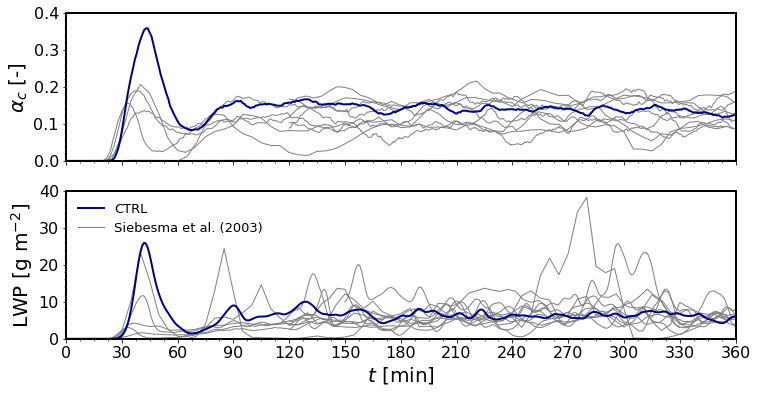

In [6]:
fig_name = "TimeEvolution_cldthres" + str(cld_threshold) + ".png"

fntSize=16
fntSize_ticks=16
plt.rcParams['xtick.labelsize']=fntSize
plt.rcParams['ytick.labelsize']=fntSize
plt.rcParams['axes.linewidth']=2.0
lineFEsize=2.0
lineSIEBsize=1.0

ts_aver = 3600*3
te_aver = 3600*6
t_diff = np.abs((time_array*sim_dt) - ts_aver)
ts_aver_ind = np.where(t_diff==np.amin(t_diff))
t_diff = np.abs((time_array*sim_dt) - te_aver)
te_aver_ind = np.where(t_diff==np.amin(t_diff))

ts_aver_ind = ts_aver_ind[0]
ts_aver_ind = ts_aver_ind[0]
te_aver_ind = te_aver_ind[0]
te_aver_ind = te_aver_ind[0]

TCC_array_aver = np.mean(TCC_array[:,ts_aver_ind:te_aver_ind],axis=1)
TCC_array_std = np.std(TCC_array[:,ts_aver_ind:te_aver_ind],axis=1)
print('average cloud fraction (3h-6h) =',TCC_array_aver)
print('std cloud fraction (3h-6h) =',TCC_array_std)

for cc in range(0,n_cases):
    time_array*sim_dt/60.0

fntSize=20
plt.rcParams['xtick.labelsize']=fntSize
plt.rcParams['ytick.labelsize']=fntSize
plt.rcParams['axes.linewidth']=2.0
numPlotsX=2
numPlotsY=1
fig,axs = plt.subplots(numPlotsX,numPlotsY,sharey=False,sharex=False,figsize=(12,6))
linecolors = ['r','b','k','tan']

ax=axs[0]
for cc in range(0,n_cases):
    im2 = ax.plot(time_array*sim_dt/60.0,TCC_array[cc,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])

for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    print('name_mm=',name_mm)
    ds = xr.open_dataset(name_mm)
    y_val = ds['alpha_ql'].values
    x_val = ds['timeH'].values
    im4 = ax.plot(x_val,y_val/100.0,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0) # ,label=legend_v[cc])
    
ax.set_ylabel(r'$\alpha_c$ $[$-$]$',fontsize=fntSize)
ax.minorticks_on()

ax.set_ylim([0,0.40])
ax.set_xlim([0,360])
ax.set_xticks([0,30,60,90,120,150,180,210,240,270,300,330,360])
ax.set_xticklabels(['','','','','','','','','','','','',''])
ax.tick_params(labelsize=fntSize_ticks)

ax=axs[1]
for cc in range(0,n_cases):
    im2 = ax.plot(time_array*sim_dt/60.0,LWP_array[cc,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])
    # compute 3-6 h averaged LWP
    ind_e = len(time_array) - 1
    t_diff = np.abs(time_array*sim_dt/60.0 - 180.0)
    ind_s = np.where(t_diff==np.amin(t_diff))
    ind_s = ind_s[0]
    ind_s = ind_s[0]
    LWP_aver_FE = np.mean(LWP_array[cc,ind_s:ind_e])
    LWP_std_FE = np.std(LWP_array[cc,ind_s:ind_e])
    print('FastEddy: LWP (3 - 6h) =',LWP_aver_FE,'g m-2 (averaged),',LWP_std_FE,'(std)')
    
for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    ds = xr.open_dataset(name_mm)
    y_val = ds['LWP'].values
    x_val = ds['timeH'].values
    if (mm==0):
        im4 = ax.plot(x_val,y_val*1e3,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val,y_val*1e3,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0) # ,label=legend_v[cc])
    # compute 3-6 h averaged LWP
    ind_e = len(x_val) - 1
    t_diff = np.abs(x_val - 180.0)
    ind_s = np.where(t_diff==np.amin(t_diff))
    ind_s = ind_s[0]
    ind_s = ind_s[0]
    LWP_aver = np.mean(y_val[ind_s:ind_e])*1e3
    LWP_std = np.std(y_val[ind_s:ind_e])*1e3
    print('BOMEX: LWP (3 - 6h) =',LWP_aver,'g m-2 (averaged),',LWP_std,'(std)')
    
ax.set_ylabel(r'LWP $[$g m$^{-2}]$',fontsize=fntSize)
ax.minorticks_on()
y_max = 1.2*np.amax(LWP_array)
ax.set_ylim([0,40.0])
ax.set_xlim([0,360])
ax.set_xticks([0,30,60,90,120,150,180,210,240,270,300,330,360])
ax.set_xticklabels(['0','30','60','90','120','150','180','210','240','270','300','330','360'])
ax.tick_params(labelsize=fntSize_ticks)
ax.set_xlabel(r'$t$ $[$min$]$',fontsize=fntSize)
ax.legend(loc=2,prop={'size': 13},edgecolor='white')

# save figure
if (save_plot_opt==1):
    CCC = path_fig_out + fig_name
    print('CCC=',CCC)
    plt.savefig(CCC,dpi=300,bbox_inches = "tight")
    #plt.close(fig)

# Planar avered profiles of theta, u, v, q_v and q_l

In [7]:
time_array_aver = np.arange(timestep_aver_s,timestep_aver_e+timestep_inc,timestep_inc) # time in time steps

time_aver_len = len(time_array_aver)

z_vec = np.zeros([n_cases+1,npz])

# 3d field dimensions #
name_tt = 'FE_BOMEX_pre.0'
file_tt = path_pre + name_tt
dataset_tt = Dataset(file_tt,'r')

zPos_tt = dataset_tt.variables['zPos'][:] # zPos
zPos_tt = zPos_tt[0,:,:,:] # z, y, x
[npz, npy, npx] = zPos_tt.shape
u_tt = dataset_tt.variables['u'][:] # u
u_tt = u_tt[0,:,:,:] 
v_tt = dataset_tt.variables['v'][:] # v
v_tt = v_tt[0,:,:,:] 
th_tt = dataset_tt.variables['theta'][:] # v
th_tt = th_tt[0,:,:,:]
rhoqv_tt = dataset_tt.variables['qv'][:] # v
rhoqv_tt = rhoqv_tt[0,:,:,:] 
rho_tt = dataset_tt.variables['rho'][:] # v
rho_tt = rho_tt[0,:,:,:]
qv_tt = rhoqv_tt # /rho_tt

u0 = u_tt[:,0,0]
v0 = v_tt[:,0,0]
qv0 = qv_tt[:,0,0]
z_vec[0,:] = zPos_tt[:,0,0]
th0 = th_tt[:,0,0]

In [8]:
u_mean = np.zeros([n_cases,time_aver_len,npz])
v_mean = np.zeros([n_cases,time_aver_len,npz])
thd_mean = np.zeros([n_cases,time_aver_len,npz])
qv_mean = np.zeros([n_cases,time_aver_len,npz])
ql_mean = np.zeros([n_cases,time_aver_len,npz])
ustar_mean = np.zeros([n_cases,time_aver_len])

#
for cc in range(0,n_cases):
    
    path_out = path_out_v[cc]
    print('path_out =',path_out)
    
    for tt in range(0,time_aver_len):
        name_tt = 'FE_BOMEX.' + str(time_array_aver[tt])
        file_tt = path_out + name_tt
        dataset_tt = Dataset(file_tt,'r')
        #
        rho_tt = dataset_tt.variables['rho'][:] # rho_d
        rho_tt = rho_tt[0,:,:,:] # x, y, z
        rhoql_tt = dataset_tt.variables['ql'][:] # q_l

        rhoqv_tt = dataset_tt.variables['qv'][:] # rho_d * q_l

        rhoql_tt = rhoql_tt[0,:,:,:] # x, y, z
        rhoqv_tt = rhoqv_tt[0,:,:,:] # x, y, z
        u_tt = dataset_tt.variables['u'][:] # u
        u_tt = u_tt[0,:,:,:] # x, y, z
        v_tt = dataset_tt.variables['v'][:] # u
        v_tt = v_tt[0,:,:,:] # x, y, z
        thd_tt = dataset_tt.variables['theta'][:] # rho_d
        thd_tt = thd_tt[0,:,:,:] # x, y, z

        ql_tt = rhoql_tt
        qv_tt = rhoqv_tt
        
        ustar_tt = dataset_tt.variables['fricVel'][:] # rho_d
        ustar_tt = ustar_tt[0,:,:] # x, y

        # mean vertical profiles
        u_mean_tmp = np.mean(np.mean(u_tt,2),1)
        v_mean_tmp = np.mean(np.mean(v_tt,2),1)
        qv_mean_tmp = np.mean(np.mean(qv_tt,2),1)
        ql_mean_tmp = np.mean(np.mean(ql_tt,2),1)
        thd_mean_tmp = np.mean(np.mean(thd_tt,2),1)
        ustar_mean_tmp = np.mean(np.mean(ustar_tt))

        u_mean[cc,tt,:] = u_mean_tmp
        v_mean[cc,tt,:] = v_mean_tmp
        qv_mean[cc,tt,:] = qv_mean_tmp
        ql_mean[cc,tt,:] = ql_mean_tmp
        thd_mean[cc,tt,:] = thd_mean_tmp
        ustar_mean[cc,tt] = ustar_mean_tmp
    
    z_tt = dataset_tt.variables['zPos'][:] # rho_d
    z_tt = z_tt[0,:,:,:] # x, y, z
    z_vec[cc+1,:] = z_tt[:,0,0]

u_mean = np.mean(u_mean,axis=1)
v_mean = np.mean(v_mean,axis=1)
qv_mean = np.mean(qv_mean,axis=1)
ql_mean = np.mean(ql_mean,axis=1)
thd_mean = np.mean(thd_mean,axis=1)

print('u_mean.shape=',u_mean.shape)
print('ustar_mean=',np.mean(ustar_mean,axis=0))
print('ustar_mean=',np.mean(ustar_mean,axis=1))

path_out = /glade/scratch/domingom/FastEddy_2022/FE_release/test_v12_BOMEX_ADV3qvHydro5th_FINAL_v3/output/
u_mean.shape= (1, 122)
ustar_mean= [0.27197719 0.27187791 0.27176875 0.27165133 0.27152911 0.27140442
 0.27127722 0.27114561 0.27100956 0.270872   0.27073485 0.2705994
 0.27046818 0.27034494 0.27023116 0.27012962 0.27004346 0.26997527
 0.26992601 0.2698954  0.26988176 0.26988122 0.26989233 0.26991183
 0.26994026 0.26998079 0.27003235 0.27008888 0.27014208 0.27018416
 0.27021176 0.27022514 0.27022305 0.27020654 0.27017763 0.27013966
 0.2700904  0.2700268  0.26994905 0.2698608  0.26976752 0.26967186
 0.26957527 0.2694785  0.26938012 0.26927713 0.26916566 0.26904482
 0.26891598 0.26878089 0.268641   0.26849756 0.26835471 0.26821712
 0.26808816 0.26796675 0.26784953 0.26773694 0.26763043 0.2675325
 0.26744366]
ustar_mean= [0.26981843]


name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/csu.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/eulag.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/inm.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/knmi.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/mpi.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/ncar.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/rams.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/ukmo.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/uok.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/uw.nc
name_mm= /glade/u/home/domingom/BOMEX_Siebesma2003_models/wvu.nc
CCC= /glade/scratch/domingom/FastEddy_2022/FE_release/test_v12_BOMEX_ADV3qvHydro5th_FINAL_v3/output/Figures_BOMEX_v2/VerticalProfiles.png


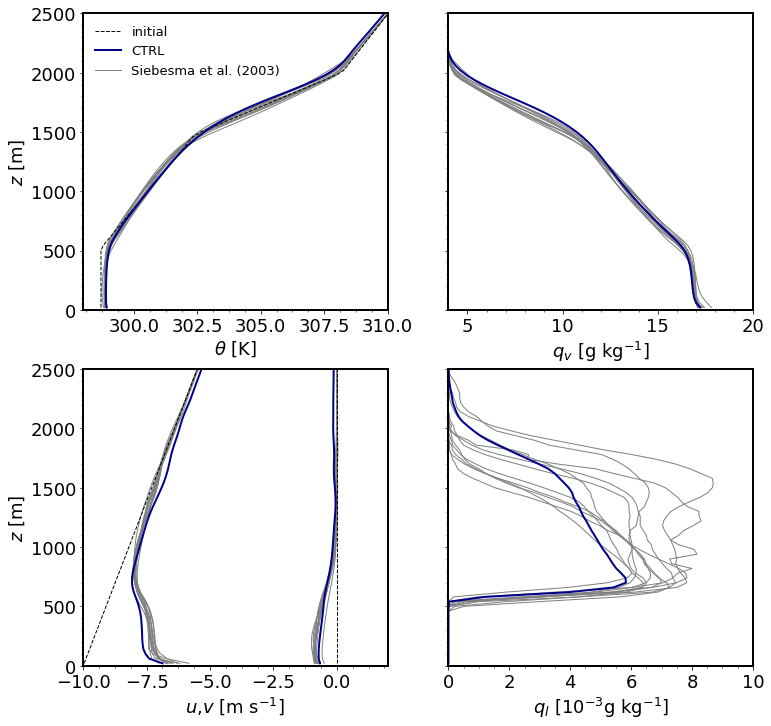

In [9]:
fig_name = "VerticalProfiles.png"

fntSize=18
plt.rcParams['xtick.labelsize']=fntSize
plt.rcParams['ytick.labelsize']=fntSize
plt.rcParams['axes.linewidth']=2.0
lineFEsize=2.0
lineSIEBsize=1.0

y_loc = [0,500,1000,1500,2000,2500]
y_loc_val = ['0','500','1000','1500','2000','2500']
y_loc_valempty = ['','','','','','']

numPlotsX=2
numPlotsY=2
fig,axs = plt.subplots(numPlotsX,numPlotsY,sharey=False,sharex=False,figsize=(12,12))
linecolors = ['r','k','b','tan']
y_max = 2500
y_min = 0

ax=axs[0,0]
im2 = ax.plot(th0,z_vec[0,:],'--',color=linecolors[1],linewidth=lineSIEBsize,markersize=8,label='initial')
for cc in range(0,n_cases):
    im2 = ax.plot(thd_mean[cc,:],z_vec[cc+1,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])

for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    print('name_mm=',name_mm)
    ds = xr.open_dataset(name_mm)
    x_val = ds['theta'].values
    x_val = np.mean(x_val[1:4,:],axis=0)
    y_val = ds['zA'].values
    if (mm==0):
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

ax.set_ylabel(r'$z$ $[$m$]$',fontsize=fntSize)
ax.set_xlabel(r'$\theta$ $[$K$]$',fontsize=fntSize)
ax.minorticks_on()
ax.set_ylim([y_min,y_max])
ax.set_xlim([298,310])
ax.set_yticks(y_loc)
ax.set_yticklabels(y_loc_val)
ax.legend(loc=0,prop={'size': 13},edgecolor='white')

ax=axs[0,1]
im2 = ax.plot(qv0,z_vec[0,:],'--',color=linecolors[1],linewidth=lineSIEBsize,markersize=8)
for cc in range(0,n_cases):
    im2 = ax.plot(qv_mean[cc,:],z_vec[cc+1,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])

for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    ds = xr.open_dataset(name_mm)
    x_val = ds['qv'].values
    x_val = np.mean(x_val[1:4,:],axis=0)
    y_val = ds['zA'].values
    if (mm==0):
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

ax.set_xlabel(r'$q_v$ $[$g kg$^{-1}]$',fontsize=fntSize)
ax.minorticks_on()
ax.set_ylim([y_min,y_max])
ax.set_xlim([4,20])
ax.set_yticks(y_loc)
ax.set_yticklabels(y_loc_valempty)

ax=axs[1,0]
im2 = ax.plot(u0,z_vec[0,:],'--',color=linecolors[1],linewidth=lineSIEBsize,markersize=8)
for cc in range(0,n_cases):
    im2 = ax.plot(u_mean[cc,:],z_vec[cc+1,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])

for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    ds = xr.open_dataset(name_mm)
    x_val = ds['u'].values
    x_val = np.mean(x_val[1:4,:],axis=0)
    y_val = ds['zA'].values
    if (mm==0):
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

im2 = ax.plot(v0,z_vec[0,:],'--',color=linecolors[1],linewidth=lineSIEBsize,markersize=8)
for cc in range(0,n_cases):
    im2 = ax.plot(v_mean[cc,:],z_vec[cc+1,:],'-',color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])

for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    ds = xr.open_dataset(name_mm)
    x_val = ds['v'].values
    x_val = np.mean(x_val[1:4,:],axis=0)
    y_val = ds['zA'].values
    if (mm==0):
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

ax.set_ylabel(r'$z$ $[$m$]$',fontsize=fntSize)
ax.set_xlabel(r'$u$,$v$ $[$m s$^{-1}]$',fontsize=fntSize)
ax.minorticks_on()
ax.set_ylim([y_min,y_max])
ax.set_xlim([-10,2])
ax.set_yticks(y_loc)
ax.set_yticklabels(y_loc_val)

ax=axs[1,1]
for cc in range(0,n_cases):
    im2 = ax.plot(ql_mean[cc,:]*1e3,z_vec[cc+1,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])

for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    ds = xr.open_dataset(name_mm)
    x_val = ds['ql'].values
    x_val = np.mean(x_val[1:4,:],axis=0)
    y_val = ds['zA'].values
    if (mm==0):
        im4 = ax.plot(x_val*1e3,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val*1e3,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

ax.set_xlabel(r'$q_l$ $[10^{-3}$g kg$^{-1}]$',fontsize=fntSize)
ax.minorticks_on()
ax.set_ylim([y_min,y_max])
    
ax.set_xlim([0,0.010*1e3])
ax.set_yticks(y_loc)
ax.set_yticklabels(y_loc_valempty)

# save figure
if (save_plot_opt==1):
    CCC = path_fig_out + fig_name
    print('CCC=',CCC)
    plt.savefig(CCC,dpi=300,bbox_inches = "tight")
    #plt.close(fig)

# Turbulent kinetic energy and vertical velocity variance

In [10]:
time_array_aver = np.arange(timestep_aver_turb_s,timestep_aver_turb_e+timestep_inc,timestep_inc) # time in time steps

time_aver_len = len(time_array_aver)

z_vec = np.zeros([n_cases+1,npz])

# 3d field dimensions #
name_tt = 'FE_BOMEX_pre.0'
file_tt = path_pre + name_tt
dataset_tt = Dataset(file_tt,'r')

zPos_tt = dataset_tt.variables['zPos'][:] # zPos
zPos_tt = zPos_tt[0,:,:,:] # z, y, x
[npz, npy, npx] = zPos_tt.shape

#
tke_mean = np.zeros([n_cases,time_aver_len,npz])
tke_tot_mean = np.zeros([n_cases,time_aver_len,npz])
sigmaw_mean = np.zeros([n_cases,time_aver_len,npz])
sigmaw_tot_mean = np.zeros([n_cases,time_aver_len,npz])
wpup_mean = np.zeros([n_cases,time_aver_len,npz])
wpvp_mean = np.zeros([n_cases,time_aver_len,npz])
w3_mean = np.zeros([n_cases,time_aver_len,npz])

wpqtotp_mean = np.zeros([n_cases,time_aver_len,npz])
wpqlp_mean = np.zeros([n_cases,time_aver_len,npz])
wpqvp_mean = np.zeros([n_cases,time_aver_len,npz])
wpthvp_mean = np.zeros([n_cases,time_aver_len,npz])
rho_mean = np.zeros([n_cases,time_aver_len,npz])
wpqtotp_tot_mean = np.zeros([n_cases,time_aver_len,npz])
wpqlp_tot_mean = np.zeros([n_cases,time_aver_len,npz])
wpqvp_tot_mean = np.zeros([n_cases,time_aver_len,npz])

#
for cc in range(0,n_cases):
    
    path_out = path_out_v[cc]
    print('path_out =',path_out)
    
    for tt in range(0,time_aver_len):
        name_tt = 'FE_BOMEX.' + str(time_array_aver[tt])
        file_tt = path_out + name_tt
        dataset_tt = Dataset(file_tt,'r')
        #
        u_tt = dataset_tt.variables['u'][:] # u
        u_tt = u_tt[0,:,:,:] # x, y, z
        v_tt = dataset_tt.variables['v'][:] # v
        v_tt = v_tt[0,:,:,:] # x, y, z
        w_tt = dataset_tt.variables['w'][:] # w
        w_tt = w_tt[0,:,:,:] # x, y, z
        sgstke_tt = dataset_tt.variables['TKE_0'][:]
        sgstke_tt = sgstke_tt[0,:,:,:] # x, y, z
        tau31_tt = dataset_tt.variables['Tau31'][:]
        tau31_tt = tau31_tt[0,:,:,:]
        tau31_tt_c = 0.5*(tau31_tt[0:npz-1,:,:]+tau31_tt[1:npz,:,:])
        tau32_tt = dataset_tt.variables['Tau32'][:]
        tau32_tt = tau32_tt[0,:,:,:]
        tau32_tt_c = 0.5*(tau32_tt[0:npz-1,:,:]+tau32_tt[1:npz,:,:])
        tau33_tt = dataset_tt.variables['Tau33'][:]
        tau33_tt = tau33_tt[0,:,:,:]
        tau33_tt_c = 0.5*(tau33_tt[0:npz-1,:,:]+tau33_tt[1:npz,:,:])
         
        qv_tt = dataset_tt.variables['qv'][:] # q_v
        qv_tt = qv_tt[0,:,:,:] # x, y, z
        ql_tt = dataset_tt.variables['ql'][:] # q_l
        ql_tt = ql_tt[0,:,:,:] # x, y, z
        qtot_tt = qv_tt + ql_tt # q_tot
        rho_tt = dataset_tt.variables['rho'][:] # rho
        rho_tt = rho_tt[0,:,:,:] # x, y, z
        th_tt = dataset_tt.variables['theta'][:] # theta
        th_tt = th_tt[0,:,:,:] # x, y, z
        thv_tt = th_tt*(1.0+0.61*qv_tt*1e-3-ql_tt*1e-3) # theta_v
        tauqv_tt = dataset_tt.variables['TauQv3'][:]
        tauqv_tt = tauqv_tt[0,:,:,:]
        tauqv_tt_c = 0.5*(tauqv_tt[0:npz-1,:,:]+tauqv_tt[1:npz,:,:])
        tauql_tt = dataset_tt.variables['TauQl3'][:]
        tauql_tt = tauql_tt[0,:,:,:]
        tauql_tt_c = 0.5*(tauql_tt[0:npz-1,:,:]+tauql_tt[1:npz,:,:])

        u_tt_mean_tmp = np.mean(np.mean(u_tt,2),1)
        v_tt_mean_tmp = np.mean(np.mean(v_tt,2),1)
        w_tt_mean_tmp = np.mean(np.mean(w_tt,2),1)

        qv_tt_mean_tmp = np.mean(np.mean(qv_tt,2),1)
        ql_tt_mean_tmp = np.mean(np.mean(ql_tt,2),1)
        qtot_tt_mean_tmp = np.mean(np.mean(qtot_tt,2),1)
        thv_tt_mean_tmp = np.mean(np.mean(thv_tt,2),1)
        rho_tt_mean_tmp = np.mean(np.mean(rho_tt,2),1)
        
        # mean vertical profiles
        up_tt = np.zeros([u_tt.shape[0],u_tt.shape[1],u_tt.shape[2]])
        vp_tt = np.zeros([u_tt.shape[0],u_tt.shape[1],u_tt.shape[2]])
        wp_tt = np.zeros([u_tt.shape[0],u_tt.shape[1],u_tt.shape[2]])
        
        qvp_tt = np.zeros([u_tt.shape[0],u_tt.shape[1],u_tt.shape[2]])
        qlp_tt = np.zeros([u_tt.shape[0],u_tt.shape[1],u_tt.shape[2]])
        qtotp_tt = np.zeros([u_tt.shape[0],u_tt.shape[1],u_tt.shape[2]])
        thvp_tt = np.zeros([u_tt.shape[0],u_tt.shape[1],u_tt.shape[2]])
        
        for kk in range(0,up_tt.shape[0]):
            up_tt[kk,:,:] = u_tt[kk,:,:] - u_tt_mean_tmp[kk]
            vp_tt[kk,:,:] = v_tt[kk,:,:] - v_tt_mean_tmp[kk]
            wp_tt[kk,:,:] = w_tt[kk,:,:] - w_tt_mean_tmp[kk]
            
        for kk in range(0,up_tt.shape[0]):
            qvp_tt[kk,:,:] = qv_tt[kk,:,:] - qv_tt_mean_tmp[kk]
            qlp_tt[kk,:,:] = ql_tt[kk,:,:] - ql_tt_mean_tmp[kk]
            qtotp_tt[kk,:,:] = qtot_tt[kk,:,:] - qtot_tt_mean_tmp[kk]
            thvp_tt[kk,:,:] = thv_tt[kk,:,:] - thv_tt_mean_tmp[kk]
        
        tke_tmp = 0.5*(up_tt*up_tt+vp_tt*vp_tt+wp_tt*wp_tt)
        tke_tmp = tke_tmp
        tke_tot_tmp = tke_tmp + sgstke_tt
        tke_mean_tmp = np.mean(np.mean(tke_tmp,2),1)
        tke_tot_mean_tmp = np.mean(np.mean(tke_tot_tmp,2),1)
        #
        sigmaw_tmp = wp_tt*wp_tt
        sigmaw_mean_tmp = np.mean(np.mean(sigmaw_tmp,2),1)
        sigmaw_tot_tmp = sigmaw_tmp
        sigmaw_tot_tmp[0:npz-1,:,:] = sigmaw_tmp[0:npz-1,:,:] + tau33_tt_c
        sigmaw_tot_mean_tmp = np.mean(np.mean(sigmaw_tot_tmp,2),1)
        
        w3_tmp = wp_tt*wp_tt*wp_tt
        w3_mean_tmp = np.mean(np.mean(w3_tmp,2),1)
        
        wpup_tmp = wp_tt*up_tt
        wpup_tmp[0:npz-1,:,:] = wpup_tmp[0:npz-1,:,:] + tau31_tt_c
        wpup_mean_tmp = np.mean(np.mean(wpup_tmp,2),1)
        
        wpvp_tmp = wp_tt*vp_tt
        wpvp_tmp[0:npz-1,:,:] = wpvp_tmp[0:npz-1,:,:] + tau32_tt_c
        wpvp_mean_tmp = np.mean(np.mean(wpvp_tmp,2),1)
        
        wpqtotp_tmp = wp_tt*qtotp_tt
        wpqtotp_mean_tmp = np.mean(np.mean(wpqtotp_tmp,2),1)

        sgswpqtotp_tt = tauqv_tt + tauql_tt
        sgswpqtotp_tt_c = 0.5*(sgswpqtotp_tt[0:npz-1,:,:]+sgswpqtotp_tt[1:npz,:,:])
        wpqtotp_tot_tmp = wpqtotp_tmp
        wpqtotp_tot_tmp[0:npz-1,:,:] = wpqtotp_tmp[0:npz-1,:,:] + sgswpqtotp_tt_c
        wpqtotp_tot_mean_tmp = np.mean(np.mean(wpqtotp_tot_tmp,2),1)

        wpqvp_tmp = wp_tt*qvp_tt
        wpqvp_mean_tmp = np.mean(np.mean(wpqvp_tmp,2),1)

        tauqv_tt_c = 0.5*(tauqv_tt[0:npz-1,:,:]+tauqv_tt[1:npz,:,:])
        wpqvp_tot_tmp = wpqvp_tmp
        wpqvp_tot_tmp[0:npz-1,:,:] = wpqvp_tmp[0:npz-1,:,:] + tauqv_tt_c
        wpqvp_tot_mean_tmp = np.mean(np.mean(wpqvp_tot_tmp,2),1)

        wpqlp_tmp = wp_tt*qlp_tt
        wpqlp_mean_tmp = np.mean(np.mean(wpqlp_tmp,2),1)

        tauql_tt_c = 0.5*(tauql_tt[0:npz-1,:,:]+tauql_tt[1:npz,:,:])
        wpqlp_tot_tmp = wpqlp_tmp
        wpqlp_tot_tmp[0:npz-1,:,:] = wpqlp_tmp[0:npz-1,:,:] + tauql_tt_c
        wpqlp_tot_mean_tmp = np.mean(np.mean(wpqlp_tot_tmp,2),1)

        wpthvp_tmp = wp_tt*thvp_tt
        wpthvp_mean_tmp = np.mean(np.mean(wpthvp_tmp,2),1)

        tke_mean[cc,tt,:] = tke_mean_tmp
        tke_tot_mean[cc,tt,:] = tke_tot_mean_tmp
        sigmaw_mean[cc,tt,:] = sigmaw_mean_tmp
        sigmaw_tot_mean[cc,tt,:] = sigmaw_tot_mean_tmp
        wpup_mean[cc,tt,:] = wpup_mean_tmp
        wpvp_mean[cc,tt,:] = wpvp_mean_tmp
        w3_mean[cc,tt,:] = w3_mean_tmp
        
        wpqtotp_mean[cc,tt,:] = wpqtotp_mean_tmp
        wpqlp_mean[cc,tt,:] = wpqlp_mean_tmp
        wpqvp_mean[cc,tt,:] = wpqvp_mean_tmp
        wpthvp_mean[cc,tt,:] = wpthvp_mean_tmp
        rho_mean[cc,tt,:] = rho_tt_mean_tmp
        wpqtotp_tot_mean[cc,tt,:] = wpqtotp_tot_mean_tmp
        wpqlp_tot_mean[cc,tt,:] = wpqlp_tot_mean_tmp
        wpqvp_tot_mean[cc,tt,:] = wpqvp_tot_mean_tmp
            
        
    z_tt = dataset_tt.variables['zPos'][:]
    z_tt = z_tt[0,:,:,:] # x, y, z
    z_vec[cc+1,:] = z_tt[:,0,0]

tke_mean_1d = np.mean(tke_mean,axis=1)
tke_tot_mean_1d = np.mean(tke_tot_mean,axis=1)
sigmaw_mean_1d = np.mean(sigmaw_mean,axis=1)
sigmaw_tot_mean_1d = np.mean(sigmaw_tot_mean,axis=1)
wpup_mean_1d = np.mean(wpup_mean,axis=1)
wpvp_mean_1d = np.mean(wpvp_mean,axis=1)
w3_mean_1d = np.mean(sigmaw_mean,axis=1)

wpqtotp_mean_1d = np.mean(wpqtotp_mean,axis=1)
wpqlp_mean_1d = np.mean(wpqlp_mean,axis=1)
wpqvp_mean_1d = np.mean(wpqvp_mean,axis=1)
wpthvp_mean_1d = np.mean(wpthvp_mean,axis=1)
rho_mean_1d = np.mean(rho_mean,axis=1)
wpqtotp_tot_mean_1d = np.mean(wpqtotp_tot_mean,axis=1)
wpqlp_tot_mean_1d = np.mean(wpqlp_tot_mean,axis=1)
wpqvp_tot_mean_1d = np.mean(wpqvp_tot_mean,axis=1)

path_out = /glade/scratch/domingom/FastEddy_2022/FE_release/test_v12_BOMEX_ADV3qvHydro5th_FINAL_v3/output/


CCC= /glade/scratch/domingom/FastEddy_2022/FE_release/test_v12_BOMEX_ADV3qvHydro5th_FINAL_v3/output/Figures_BOMEX_v2/VerticalProfilesTurb.png


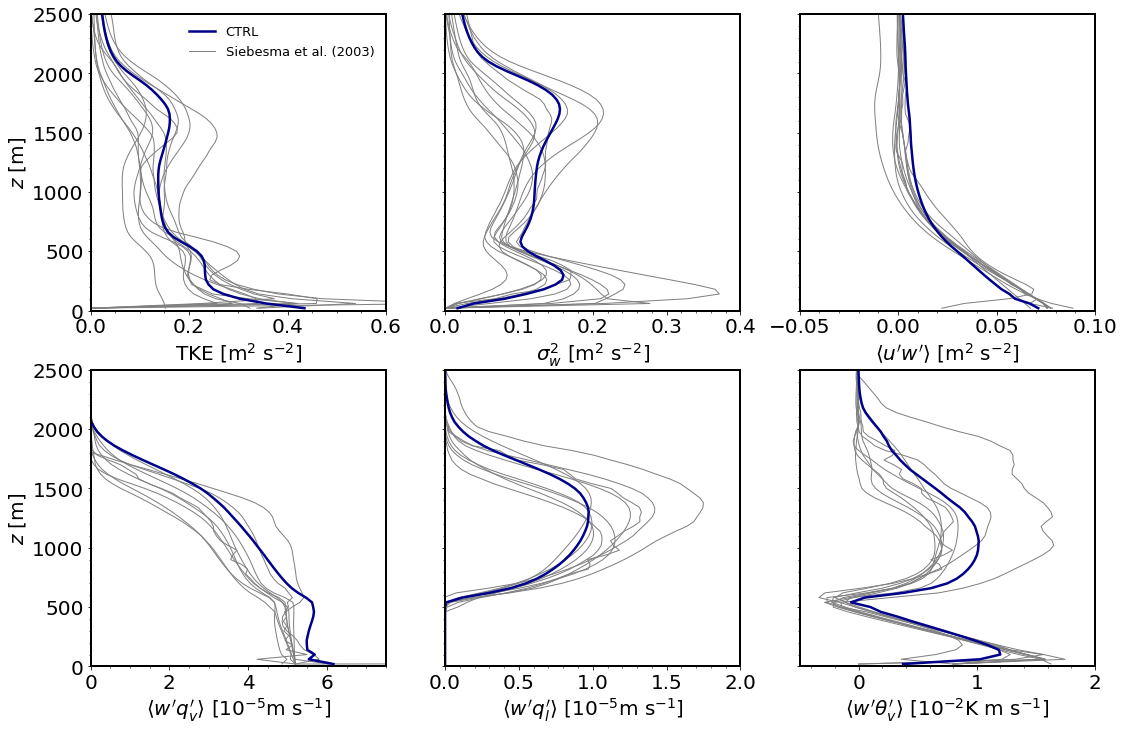

In [11]:
fig_name = "VerticalProfilesTurb.png"

fntSize=20
plt.rcParams['xtick.labelsize']=fntSize
plt.rcParams['ytick.labelsize']=fntSize
plt.rcParams['axes.linewidth']=2.0
numPlotsX=2
numPlotsY=3
fig,axs = plt.subplots(numPlotsX,numPlotsY,sharey=False,sharex=False,figsize=(18,12))
linecolors = ['r','b','k','tan']
y_max = 2500
y_min = 0

lineFEsize=2.5
lineSIEBsize=1.0

y_loc = [0,500,1000,1500,2000,2500]
y_loc_val = ['0','500','1000','1500','2000','2500']
y_loc_valempty = ['','','','','','']

ax=axs[0,0]
for cc in range(0,n_cases):
    im2 = ax.plot(tke_tot_mean_1d[cc,:],z_vec[cc+1,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])

for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    ds = xr.open_dataset(name_mm)
    x_val = ds['ww'].values
    x_val2 = ds['UU'].values
    x_val = 0.5*(x_val + x_val2)
    x_val = np.mean(x_val[1:4,:],axis=0)
    y_val = ds['zA'].values
    
    if (mm==0):
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

ax.set_ylabel(r'$z$ $[$m$]$',fontsize=fntSize)
ax.set_xlabel(r'TKE $[$m$^2$ s$^{-2}]$',fontsize=fntSize)
ax.minorticks_on()
ax.set_ylim([y_min,y_max])
ax.set_xlim([0,0.6])
ax.legend(loc=0,prop={'size': 13},edgecolor='white')
ax.set_yticks(y_loc)
ax.set_yticklabels(y_loc_val)

ax=axs[0,1]
for cc in range(0,n_cases):
    im2 = ax.plot(sigmaw_mean_1d[cc,:],z_vec[cc+1,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])

for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    ds = xr.open_dataset(name_mm)
    x_val = ds['ww'].values
    x_val = np.mean(x_val[1:4,:],axis=0)
    y_val = ds['zA'].values
    if (mm==0):
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

ax.set_xlabel(r'$\sigma_w^2$ $[$m$^2$ s$^{-2}]$',fontsize=fntSize)
ax.minorticks_on()
ax.set_ylim([y_min,y_max])
ax.set_xlim([0,0.4])
ax.set_yticks(y_loc)
ax.set_yticklabels(y_loc_valempty)

ax=axs[0,2]
for cc in range(0,n_cases):
    im2 = ax.plot(wpup_mean_1d[cc,:],z_vec[cc+1,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])
    
for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    ds = xr.open_dataset(name_mm)
    x_val = ds['uw'].values
    x_val = np.mean(x_val[1:4,:],axis=0)
    y_val = ds['zA'].values
    
    if (mm==0):
        im4 = ax.plot(x_val*1e-2,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val*1e-2,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

ax.set_xlabel(r"$\langle u' w' \rangle$ [m$^2$ s$^{-2}]$",fontsize=fntSize)
ax.minorticks_on()
ax.set_ylim([y_min,y_max])
ax.set_xlim([-0.05,0.1])
ax.set_yticks(y_loc)
ax.set_yticklabels(y_loc_valempty)

ax=axs[1,0]
for cc in range(0,n_cases):
    im2 = ax.plot(wpqvp_tot_mean_1d[cc,:]*1e-3*1e5,z_vec[cc+1,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])
    
for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    ds = xr.open_dataset(name_mm)
    x_val = ds['wqt'].values
    x_val2 = ds['wql'].values
    x_val = x_val - x_val2
    x_val = np.mean(x_val[1:4,:],axis=0)
    y_val = ds['zA'].values
    
    if (mm==0):
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

ax.set_ylabel(r'$z$ $[$m$]$',fontsize=fntSize)
ax.set_xlabel(r"$\langle w' q_v' \rangle$ [10$^{-5}$m s$^{-1}]$",fontsize=fntSize)
ax.minorticks_on()
ax.set_ylim([y_min,y_max])
ax.set_xlim([0,7.5])
ax.set_yticks(y_loc)
ax.set_yticklabels(y_loc_val)

ax=axs[1,1]
for cc in range(0,n_cases):
    im2 = ax.plot(wpqlp_tot_mean_1d[cc,:]*1e-3*1e5,z_vec[cc+1,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])

for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    ds = xr.open_dataset(name_mm)
    x_val = ds['wql'].values
    x_val = np.mean(x_val[1:4,:],axis=0)
    y_val = ds['zA'].values
    if (mm==0):
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
    else:
        im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

ax.set_xlabel(r"$\langle w' q_l' \rangle$ [10$^{-5}$m s$^{-1}]$",fontsize=fntSize)
ax.minorticks_on()
ax.set_ylim([y_min,y_max])
ax.set_xlim([0,2.0])
ax.set_yticks(y_loc)
ax.set_yticklabels(y_loc_valempty)

ax=axs[1,2]
for cc in range(0,n_cases):
    im2 = ax.plot(wpthvp_mean_1d[cc,:]*1e2,z_vec[cc+1,:],linestyle=lineas[cc],color=colores[cc],linewidth=lineFEsize,markersize=8,label=legend_v[cc])
    
for mm in range(0,n_sieb):
    name_mm = path_sieb + models_sieb[mm] + '.nc'
    
    if (models_sieb[mm]!='knmi'):
        ds = xr.open_dataset(name_mm)
        x_val = ds['wthv'].values
        x_val = np.mean(x_val[1:4,:],axis=0)
        y_val = ds['zA'].values

        if (mm==0):
            im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0,label='Siebesma et al. (2003)')
        else:
            im4 = ax.plot(x_val,y_val,'-',color='gray',linewidth=lineSIEBsize,markersize=8,zorder=0)

ax.set_xlabel(r"$\langle w' \theta_v' \rangle$ [10$^{-2}$K m s$^{-1}]$",fontsize=fntSize)
ax.minorticks_on()
ax.set_ylim([y_min,y_max])
ax.set_xlim([-0.5,2.0])
ax.set_yticks(y_loc)
ax.set_yticklabels(y_loc_valempty)


# save figure
if (save_plot_opt==1):
    CCC = path_fig_out + fig_name
    plt.savefig(CCC,dpi=300,bbox_inches = "tight")
    print('CCC=',CCC)
    #plt.close(fig)